# Pair-distribution function, reverse Monte Carle Analysis Code (PDF-RMC)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
import pandas as pd
import openpyxl
import math
from numpy import sqrt
from scipy import interpolate
from pdf_rmc import *

## Setting up structure, Debye scattering

Here, we are setting ourselves up a 3d structure and associated $I(q)$ to compare our experimentally-collected PDF data to. That is, we will start with a proposed structure of $N$ atoms with associated $(x, y, z)$ coordinates. Following Debye scattering theory, we will then compute $I(q)$ for this structure which can easily be converted to the pair-distribtuion function (PDF) later. Recall that in the grand scheme of our analysis, this structure and in turn its $I(q)$ will be modified atom-by-atom using the reverse Monte Carlo (RMC) methodology to match the expireementally collected data and its computed PDF.

We begin by opening our .pdb file. PDB is an acronym for "Protein Data Bank," describing th 3D structure of proteins and other molecules; importantly, it provides 3 coordinates for each atom in the structure and the type of atom. This is a not the most common data format in x-ray scattering studies, but it is easy to go from .cif (perhaps a more commmon data type) to .pdb. Here are some relevant resources:
* https://en.wikipedia.org/wiki/Protein_Data_Bank_(file_format)
* https://www.iucr.org/resources/cif/software/cif2pdb
* https://www.ccp4.ac.uk/html/pdbset.html

After opening the file, we extract the important information into a convenient format. For each atom in the structure, we store its initial $(x, y, z)$ coordinates as well as the type of atom. Here, I've chosen to create two arrays, one storing the coordinates, another storing the type of atom. So, for a system of $N$ atoms, I've created one $N \times 3$ array and one $N \times 1$ array.

It's worth noting that I often modify this section by hand manually to handle structures that I get from different sources. Vesta-cut .pdb files often look a little different than single crystal or DFT .pdb files, so sometimes I spend a few minutes modifying this bit of code to work with some kind of different structure.

Note too that there is a function imported, "XYZ_import" that works with .xyz files. See "pdf_rmc.py" to see this function; it does essentially the same thing.

In [141]:
#This cell works with Cd37S18 structure from OV

pdbfile = open(r"Cd37S18-relaxed.pdb")
pdbdata = pdbfile.readlines()
pdbarray = pdbdata[5:60]
number_of_atoms = len(pdbarray)
Array_init = np.zeros((number_of_atoms,3))
x_coordinate=np.zeros((number_of_atoms,))
y_coordinate=np.zeros((number_of_atoms,))
z_coordinate=np.zeros((number_of_atoms,))
atom_type=[]

for i in range (0,number_of_atoms):
    seperate = pdbarray[i].split()
    Array_init[i] = [float(seperate[5])]+[float(seperate[6])]+[float(seperate[7])]
    x_coordinate[i] = Array_init[i][0]
    y_coordinate[i] = Array_init[i][1]
    z_coordinate[i] = Array_init[i][2]
    if seperate[10]=='CD':
        atom_type.insert(i,'Cd')
    else:
        atom_type.insert(i, 'S')
            
for i in range (0,number_of_atoms):
    Array_init[i] = [Array_init[i][0]-np.mean(x_coordinate)]+\
                    [Array_init[i][1]-np.mean(y_coordinate)]+\
                    [Array_init[i][2]-np.mean(z_coordinate)]

In [107]:
#This cell works with Cd37S20 published in Science

pdbfile = open(r"F324 - papertrail.pdb")
pdbdata = pdbfile.readlines()
pdbarray = pdbdata[2:59]
number_of_atoms = len(pdbarray)
Array_init = np.zeros((number_of_atoms,3))
x_coordinate=np.zeros((number_of_atoms,))
y_coordinate=np.zeros((number_of_atoms,))
z_coordinate=np.zeros((number_of_atoms,))
atom_type=[]

for i in range (0,number_of_atoms):
    seperate = pdbarray[i].split()
    Array_init[i] = [float(seperate[3])]+[float(seperate[4])]+[float(seperate[5])]
    x_coordinate[i] = Array_init[i][0]
    y_coordinate[i] = Array_init[i][1]
    z_coordinate[i] = Array_init[i][2]
    if seperate[8]=='CD':
        atom_type.insert(i,'Cd')
    else:
        atom_type.insert(i, 'S')
            
for i in range (0,number_of_atoms):
    Array_init[i] = [Array_init[i][0]-np.mean(x_coordinate)]+\
                    [Array_init[i][1]-np.mean(y_coordinate)]+\
                    [Array_init[i][2]-np.mean(z_coordinate)]

In [3]:
#This cell works with I, P, C, and H ligands on surface

pdbfile = open(r"Cd28S17_with_CH.pdb")
pdbdata = pdbfile.readlines()
pdbarray = pdbdata[2:270]
number_of_atoms = len(pdbarray)
Array_init = np.zeros((number_of_atoms,3))
x_coordinate=np.zeros((number_of_atoms,))
y_coordinate=np.zeros((number_of_atoms,))
z_coordinate=np.zeros((number_of_atoms,))
atom_type=[]

for i in range (0,number_of_atoms):
    seperate = pdbarray[i].split()
    Array_init[i] = [float(seperate[3])]+[float(seperate[4])]+[float(seperate[5])]
    x_coordinate[i] = Array_init[i][0]
    y_coordinate[i] = Array_init[i][1]
    z_coordinate[i] = Array_init[i][2]
    if seperate[8] =='CD':
        atom_type.insert(i,'Cd')
    elif seperate[8] =='S':
        atom_type.insert(i, 'S')
    elif seperate[8] =='C':
        atom_type.insert(i, 'C')
    elif seperate[8] =='P':
        atom_type.insert(i, 'P')
    elif seperate[8] =='I':
        atom_type.insert(i,'I')
    else:
        atom_type.insert(i,'H')
            
for i in range (0,number_of_atoms):
    Array_init[i] = [Array_init[i][0]-np.mean(x_coordinate)]+\
                    [Array_init[i][1]-np.mean(y_coordinate)]+\
                    [Array_init[i][2]-np.mean(z_coordinate)]

In [100]:
#This cell works without ligands on surface

pdbfile = open(r"Cd28S17_without_IPCH.pdb")
pdbdata = pdbfile.readlines()
pdbarray = pdbdata[2:47]
number_of_atoms = len(pdbarray)
Array_init = np.zeros((number_of_atoms,3))
x_coordinate=np.zeros((number_of_atoms,))
y_coordinate=np.zeros((number_of_atoms,))
z_coordinate=np.zeros((number_of_atoms,))
atom_type=[]

for i in range (0,number_of_atoms):
    seperate = pdbarray[i].split()
    Array_init[i] = [float(seperate[3])]+[float(seperate[4])]+[float(seperate[5])]
    x_coordinate[i] = Array_init[i][0]
    y_coordinate[i] = Array_init[i][1]
    z_coordinate[i] = Array_init[i][2]
    if seperate[8] =='CD':
        atom_type.insert(i,'Cd')
    else: #need to modify this line to deal with I, P, C, and H
        atom_type.insert(i, 'S')
            
for i in range (0,number_of_atoms):
    Array_init[i] = [Array_init[i][0]-np.mean(x_coordinate)]+\
                    [Array_init[i][1]-np.mean(y_coordinate)]+\
                    [Array_init[i][2]-np.mean(z_coordinate)]

Now, we generate our atomic form factors, r-space, q-space, and "form factor" space. These are generated from functions imported from another script. We need this to calculate $I(q)$ from the Debye scattering equation.

The atomic form factors are generated from tabular values for each element/isotope/etc. We later will use these values to subtract the atomic scattering from our total scattering data, leaving us with pair scattering, relevant for our analysis.

**add comments on r-space, ff-space, q-space** // in-progress

In [108]:
start = datetime.datetime.now()
Formfactors = factor(atom_type,number_of_atoms)                          #Loading atomic scattering factors from spreadsheet.
r_space_initial = r_space_generation(Array_init,number_of_atoms)         
ff_space_initial = factor_space_generation(Formfactors,number_of_atoms)  #These lines are creating arrays that we need from the table of values and imported structure
q_space_initial = q_space_generation(number_of_atoms)
end = datetime.datetime.now()
print (end-start)

0:00:27.923490


Finally, we compute $I(q)$ using Debye scattering theory. The Debye scattering equation can be written in a few ways, here are two examples:

$$I(q) = \sum_i \sum_j f_i f_j e^{i q \cdot (r_i - r_j)} = \sum_i \sum_j f_i f_j
\frac{\sin(Q r_{ij})}{Q r_{ij}}$$

For details on the used function, see the pdf_rmc counterpart to this code (might be named differently, look at which version is imported). We have used a form of the Debye scattering equation based on a Taylor expansion of the equation; this simplifies the double sum into a sum of two functions.

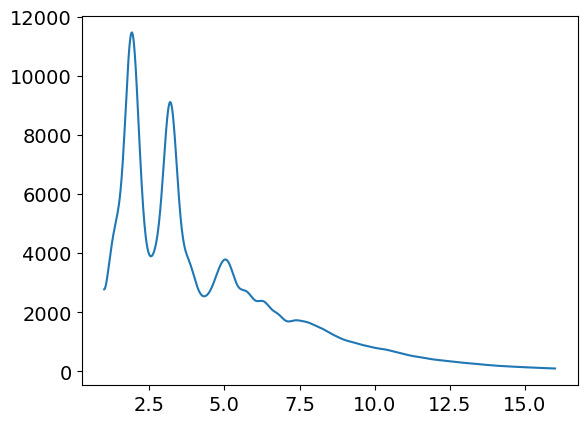

In [109]:
I_Q_initial = debye(q_space_initial,ff_space_initial,r_space_initial,0.1,Formfactors) #creating I(q) from Debye scattering equation
plt.plot(q_space_initial[:, 0, 0], I_Q_initial)

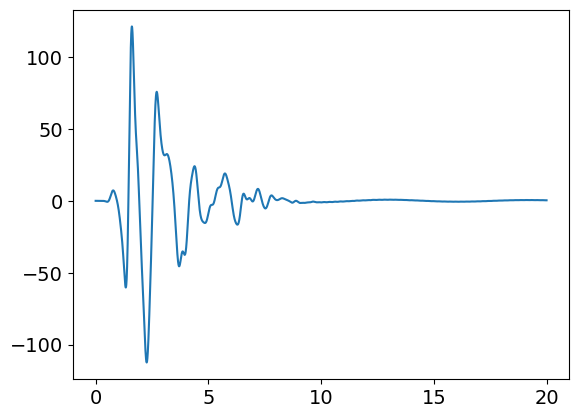

In [110]:
G_Rsimu, Bsimu, Fqsimu = G_R_generation(I_Q_initial,0,Formfactors) #Computing PDF from I(q) computed above
r = np.linspace(0,20,4001)

plt.plot(r, G_Rsimu)

In [15]:
#IMPORTING EXPERIMENTAL DATA HERE
#If you hvae G(r) already processed/saved, could just import that here. Here, I import raw I(q) data and background sub, process to G(r)

## --- with solid-angle corrections, no bkgd subtracted
filename = r"A_1_CdS_MSC_324_20230616-160807_496bc7_primary-dk_sub_image-0.chi"
data = pd.read_csv(filename, sep="  ", header=None, skiprows=4)
dataarr = data.to_numpy()
Q_import = dataarr[:,0]
I_import = dataarr[:,1]

# Going to do some bkgd subtraction here
kapt_file = r"A_empty_kapton_capillary_20230616-121155_fc6f8e_primary-dk_sub_image-0.chi"
kapt_dat = pd.read_csv(kapt_file, sep="  ", header=None, skiprows=4)
kapt_arr = kapt_dat.to_numpy()
Q_kapt = kapt_arr[:,0]
I_kapt = kapt_arr[:,1]

# truncating I(q) to the usable q range [~0.6 - 26 invA from June 2023 BNL run]
C = 0.33
n1=1
n2=26
# plt.scatter(Q_kapt, C*I_kapt, label='blank kapton capillary, rescaled', s=2)
# plt.scatter(Q_import, I_import, label='sample', s=2)
# plt.scatter(Q_import, I_import - C*I_kapt, label='sample minus kapton', s=2)
# plt.xlim(n1,n2)
# plt.ylim(0, 17500)
# plt.xlabel(r'$q$ $(\AA ^{-1})$')
# plt.ylabel(r'$I(q)$')
# plt.legend(loc='upper right')
# plt.title('Background Subtraction')
# plt.show()
I_new = I_import - C*I_kapt
I_trunc = I_new[Q_import > n1]
Q_trunc = Q_import[Q_import > n1]
I_trunc = I_trunc[Q_trunc < n2]
Q_trunc = Q_trunc[Q_trunc < n2]
Form_Factor = correctness()
Q_arr = np.linspace(min(Q_trunc),max(Q_trunc),1501)
I_arr = np.interp(Q_arr,Q_trunc,I_trunc)
I_arr324 = I_arr 

G_Rexpt, Bexpt, F_qexpt = G_R_generation(I_arr324,0,Formfactors)
r = np.linspace(0,20,4001)

# plt.scatter(r, G_Rexpt/max(G_Rexpt), label='experimental')
# plt.scatter(r, G_Rsimu/max(G_Rsimu), label='initial')
# plt.legend(loc='best')
# plt.xlim(1,20)


C:\Users\12155\AppData\Local\Temp\ipykernel_44768\3146928225.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(filename, sep="  ", header=None, skiprows=4)
C:\Users\12155\AppData\Local\Temp\ipykernel_44768\3146928225.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  kapt_dat = pd.read_csv(kapt_file, sep="  ", header=None, skiprows=4)


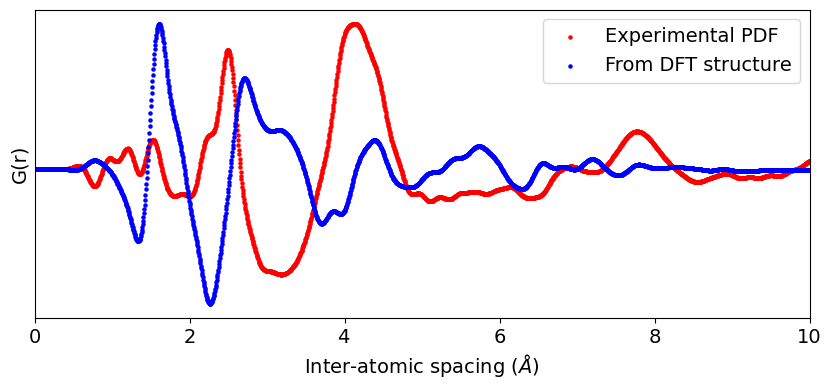

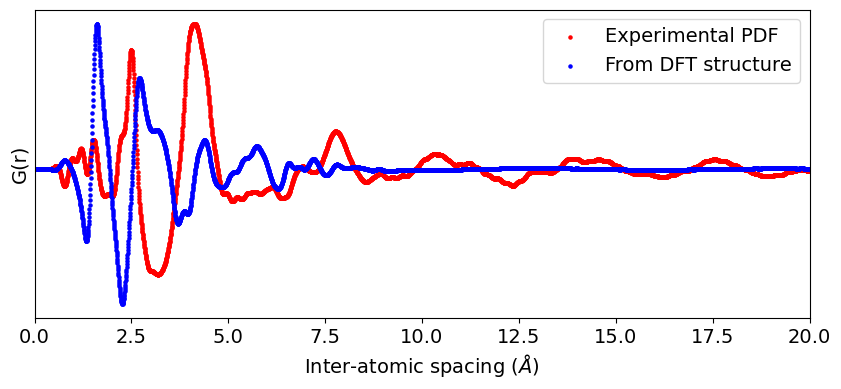

In [111]:
# fig, ax = plt.subplots(figsize=(10,4))
# plt.scatter(r, G_Rexpt / np.max(G_Rexpt), color='red', s=5, label='Experimental PDF')
# plt.scatter(r, G_Rsimu / np.max(G_Rsimu), color='blue', s=5, label='From DFT structure')
# plt.xlim(0,10)
# plt.tick_params(axis='y', which='both', left=False, labelleft=False)
# plt.xlabel(r'Inter-atomic spacing ($\AA$)')
# plt.ylabel(r'G(r)')
# plt.legend(loc='best')
# plt.show()

fig, ax = plt.subplots(figsize=(10,4))
plt.scatter(r, G_Rexpt / np.max(G_Rexpt), color='red', s=5, label='Experimental PDF')
plt.scatter(r, G_Rsimu / np.max(G_Rsimu), color='blue', s=5, label='From DFT structure')
plt.xlim(0,20)
plt.tick_params(axis='y', which='both', left=False, labelleft=False)
plt.xlabel(r'Inter-atomic spacing ($\AA$)')
plt.ylabel(r'G(r)')
plt.legend(loc='best')
plt.show()

# resid_initial = sqrt(sum((Exp_compare.copy()[0:1801]-G_R_compare_initial[0:1801])**2)/sum(Exp_compare.copy()[0:1801]**2))
# print(resid_initial)

## Computing PDF
Some of the code below here is a bit scuffed, since it's legacy code. I'm working on cleaning it up, adding notes, so that it can be better interpreted, modified, improved.

In [112]:
file = pd.read_excel(r"I_TB_collaborator.xlsx", engine='openpyxl')
# file = xlrd.open_workbook(file)
# data = file.sheet_by_name('Sheet1')
I_TB = np.zeros((100,1501))
for i in range (0,99):
    I_TB[i] = file.iloc[i,:1501]
# THIS CELL NEEDS TO BE CHECKED THAT ITS CORRECT. LEGACY CODE WAS OUTDATED. I DONT THINK I UNDERSTAND I_TB.

In [113]:
I_Board = debye(q_space_initial,ff_space_initial,r_space_initial,0.32,Formfactors)

In [114]:
stu_1 = I_TB[1,:] - 5*I_Board        
stu = mean(stu_1,0)
# CHECK THIS CELL, HAD TO ADD INDEXTING TO I_TB

In [104]:
# here is another variable we need to input to rmc codes
file3 = open(r"OA XRD SC 1-16q 74 molecule.txt")
data3 = file3.readlines()
Org = np.zeros((len(data3),))                       # this store the I_Q space from the file
for i in range (0,len(data3)):
    Org[i] = float(data3[i])
file3.close()

In [129]:
#This cell was kinda trash before. Re-writing. If it's even necessary...not sure that it is, maybe outdated from the legacy.
Form_factor = correctness()
XRD_initial = (stu+I_Q_initial+Org)/3
# Exp_compare = G_Rexpt/np.max(G_Rexpt)  #changed this name since the indexing was giving me a problem. Made a new exp compare from my code
simu_compare = G_Rsimu/np.max(G_Rsimu)



filename = r"F324 - XRD - 1-16q - RT - cryo.txt"
data0 = np.loadtxt(filename, usecols=(1))
data1 = np.loadtxt(filename, usecols=(0))
alpha = np.zeros((len(data0),))                       
for i in range (0,len(data0)):
    alpha[i] = float(data0[i])
alpha_0 = np.zeros((len(data1),))
for i in range (0,len(data1)):
    alpha_0[i] = float(data1[i])
Form_Factor = correctness()
new_IvsQ_len = np.linspace(min(alpha_0),16,1501) #using this line because not much info in high-q range
new_IvsQ = np.interp(new_IvsQ_len,alpha_0,alpha)
Exp_pdf, B_exp, Fqexp = G_R_generation(new_IvsQ,0.1,Form_Factor)
Exp_compare = Exp_pdf/np.max(Exp_pdf)

G_R_initial, Binitial, Fq_initial = G_R_generation(XRD_initial,0,Form_factor)
G_R_compare_initial = G_R_initial/np.max(G_R_initial)

resid_initial = sqrt(sum((Exp_compare.copy()[0:1801]-G_R_compare_initial[0:1801])**2)/sum(Exp_compare.copy()[0:1801]**2))
print(resid_initial)



# resid_init = sqrt(sum((Exp_compare-simu_compare)**2)/sum(Exp_compare**2))
# resid_init2 = sqrt(sum((Exp_compare.copy()[0:1801]-simu_compare_moved[0:1801])**2)/sum(Exp_compare.copy()[0:1801]**2))
# print(resid_init)
# print(resid_init2)

1.012091258162439


## RMC time... plan to wait a few minutes!

Now we're finally at the point where we can run the RMC. We have everything necessary prepared, namely:
* a proposed 3d atomic structure
* code to compute $I(q)$, $G(r)$ for the proposed structure via Debye scattering equation
* computed/measured $G(r)$ from experimental total scattering data

The RMC workflow is straightforward:
1. input initial structure & implement constraint(s)
2. select & move an atom randomly by a fraction of an Angstrom
3. simulate diffraction for modified structure & compute PDF
4. Calculate residual b/w experimental & theoretical $G(r)$
5. If residual decreases, accept move and return to step 2; if residual increases, decline move and return to step 2

In [137]:
starttime = datetime.datetime.now()
resid_array= np.zeros((10000,))
iter_array= np.zeros((10000,))
rmc = 0
array_move_store = Array_init.copy()
resid_array[0] = resid_init
iter_array[0] = rmc

while rmc < 1000:
    array_current = array_move_store.copy()
    Sel = random.randint(0,number_of_atoms-1)                     #Randomly selecting an atom from the structure to move
    The = 180*random.random()                                     #Randomly picking directions to mvoe the atom
    Phi = 360*random.random()
    Rad = 0.1*random.random()                                     #This factor of 0.1 is the difference in angstroms that it will move
    Rand = Rad * np.array([sin(The*180/pi)*cos(Phi*180/pi), \
                          sin(The*180/pi)*sin(Phi*180/pi),\
                          cos(The*180/pi)])                       #Making into array to be added to the currrent position (next line)
    array_current[Sel] = array_current[Sel] + Rand
    
    r_space_moved = r_space_generation(array_current,number_of_atoms)   
    ff_space_moved = ff_space_initial.copy()
    q_space_moved = q_space_initial.copy()
    
    I_Q_moved = debye(q_space_moved,ff_space_moved,r_space_moved,0.1,Formfactors)
    XRD_moved = (I_Q_moved + stu + Org)/3
    G_Rsimu_moved, Bsimu_moved, Fqsimu_moved = G_R_generation(XRD_moved,0,Form_factor)
            
    
    simu_compare_moved = G_Rsimu_moved/np.max(G_Rsimu_moved)
    
    # If you want to focus on improving the residual in the low-r region, for example, you can use array slicing in the next line...
    new_residue=sqrt(sum((Exp_compare.copy()-simu_compare_moved)**2)/sum(Exp_compare.copy()**2))
    

    if new_residue > resid_array[rmc]:
        rmc = rmc - 1
   
    else:
        array_move_store = array_current
        resid_array[rmc+1]= new_residue
        iter_array[rmc+1] = rmc
        print('move #: ', rmc, r', R_W: ', new_residue)
        
    rmc = rmc+1
endtime = datetime.datetime.now()
print (endtime - starttime)

move #:  0 , R_W:  1.0341868284614946
move #:  1 , R_W:  1.0336352660683954
move #:  2 , R_W:  1.0315750448944776
move #:  3 , R_W:  1.030849817853336
move #:  4 , R_W:  1.0302082904666985
move #:  5 , R_W:  1.0288997570563827
move #:  6 , R_W:  1.0283910413284745
move #:  7 , R_W:  1.0281303683113718
move #:  8 , R_W:  1.0280408103508556
move #:  9 , R_W:  1.026808037412319
move #:  10 , R_W:  1.026764214791922
move #:  11 , R_W:  1.0250907860346246
move #:  12 , R_W:  1.0246947452338702
move #:  13 , R_W:  1.02396456492163
move #:  14 , R_W:  1.0226421168475341
move #:  15 , R_W:  1.022622110985189
move #:  16 , R_W:  1.0224612576096428
move #:  17 , R_W:  1.022409256914836
move #:  18 , R_W:  1.0213234790328523
move #:  19 , R_W:  1.0164366853743605
move #:  20 , R_W:  1.016222423652336
move #:  21 , R_W:  1.01606048665322
move #:  22 , R_W:  1.0157991878841497
move #:  23 , R_W:  1.0156787359551909
move #:  24 , R_W:  1.012959753311554
move #:  25 , R_W:  1.0111575740377943
move #:

move #:  209 , R_W:  0.8640719715301668
move #:  210 , R_W:  0.8636578715864964
move #:  211 , R_W:  0.8636167793754543
move #:  212 , R_W:  0.8632276557288386
move #:  213 , R_W:  0.8619287778273449
move #:  214 , R_W:  0.8616604650529929
move #:  215 , R_W:  0.8616553345269145
move #:  216 , R_W:  0.8614899274445755
move #:  217 , R_W:  0.8612411448662394
move #:  218 , R_W:  0.861105758329099
move #:  219 , R_W:  0.8610850950355456
move #:  220 , R_W:  0.8608245757741412
move #:  221 , R_W:  0.8607840925528698
move #:  222 , R_W:  0.8606043654469028
move #:  223 , R_W:  0.8602147481120235
move #:  224 , R_W:  0.8589244582691805
move #:  225 , R_W:  0.8579016136556119
move #:  226 , R_W:  0.8578632080907316
move #:  227 , R_W:  0.8576655764288744
move #:  228 , R_W:  0.8576217152854456
move #:  229 , R_W:  0.8566854619818894
move #:  230 , R_W:  0.855427535727846
move #:  231 , R_W:  0.8540827182728554
move #:  232 , R_W:  0.8538258140501089
move #:  233 , R_W:  0.8533289088510158
mo

move #:  415 , R_W:  0.8015849480442746
move #:  416 , R_W:  0.8015678895664132
move #:  417 , R_W:  0.8015500764164276
move #:  418 , R_W:  0.8015161446683542
move #:  419 , R_W:  0.801437713067742
move #:  420 , R_W:  0.801302900772531
move #:  421 , R_W:  0.8011082263497061
move #:  422 , R_W:  0.8009471338994196
move #:  423 , R_W:  0.8009125478424606
move #:  424 , R_W:  0.8005174947234187
move #:  425 , R_W:  0.8005172026235622
move #:  426 , R_W:  0.8005078288840638
move #:  427 , R_W:  0.8004589875723366
move #:  428 , R_W:  0.8003041006570837
move #:  429 , R_W:  0.800304042862355
move #:  430 , R_W:  0.8001301622887083
move #:  431 , R_W:  0.7995688827809888
move #:  432 , R_W:  0.7993578366911633
move #:  433 , R_W:  0.7987990949496958
move #:  434 , R_W:  0.7987747336475811
move #:  435 , R_W:  0.7987689310072796
move #:  436 , R_W:  0.7981382875125329
move #:  437 , R_W:  0.7979338093905703
move #:  438 , R_W:  0.7979119357016509
move #:  439 , R_W:  0.7978844913680888
mov

move #:  621 , R_W:  0.7745366449528339
move #:  622 , R_W:  0.7744534772719067
move #:  623 , R_W:  0.7744288506437753
move #:  624 , R_W:  0.774371034562412
move #:  625 , R_W:  0.7741923663920051
move #:  626 , R_W:  0.7740042527894526
move #:  627 , R_W:  0.7738236274386844
move #:  628 , R_W:  0.7737149897304102
move #:  629 , R_W:  0.773473715464064
move #:  630 , R_W:  0.7734383041742117
move #:  631 , R_W:  0.7733631255251561
move #:  632 , R_W:  0.7732369416741482
move #:  633 , R_W:  0.7731953083150062
move #:  634 , R_W:  0.7729007860314722
move #:  635 , R_W:  0.7727671659478526
move #:  636 , R_W:  0.7727496563846308
move #:  637 , R_W:  0.7727486537315341
move #:  638 , R_W:  0.7727433982627516
move #:  639 , R_W:  0.7727378902508193
move #:  640 , R_W:  0.7726853268622378
move #:  641 , R_W:  0.77265467900592
move #:  642 , R_W:  0.7725141356133406
move #:  643 , R_W:  0.7721571149718299
move #:  644 , R_W:  0.7721123412369939
move #:  645 , R_W:  0.77210189337174
move #

move #:  827 , R_W:  0.7558415476891874
move #:  828 , R_W:  0.755811106579443
move #:  829 , R_W:  0.7557952979428292
move #:  830 , R_W:  0.7557135999078791
move #:  831 , R_W:  0.7556680967512921
move #:  832 , R_W:  0.7556663983819684
move #:  833 , R_W:  0.7556455802138305
move #:  834 , R_W:  0.7556155566898327
move #:  835 , R_W:  0.7556117363888347
move #:  836 , R_W:  0.7555890241275627
move #:  837 , R_W:  0.7555429626181329
move #:  838 , R_W:  0.7554955061066594
move #:  839 , R_W:  0.7554610428457047
move #:  840 , R_W:  0.7554360793825442
move #:  841 , R_W:  0.7554286511539411
move #:  842 , R_W:  0.75537210965592
move #:  843 , R_W:  0.7551448132197036
move #:  844 , R_W:  0.75514195939887
move #:  845 , R_W:  0.7551063560992615
move #:  846 , R_W:  0.7550693223009322
move #:  847 , R_W:  0.7550515702116707
move #:  848 , R_W:  0.755047772254848
move #:  849 , R_W:  0.7549682710212408
move #:  850 , R_W:  0.7549521667870381
move #:  851 , R_W:  0.7549353777734633
move #

Text(0, 0.5, '$R_W$')

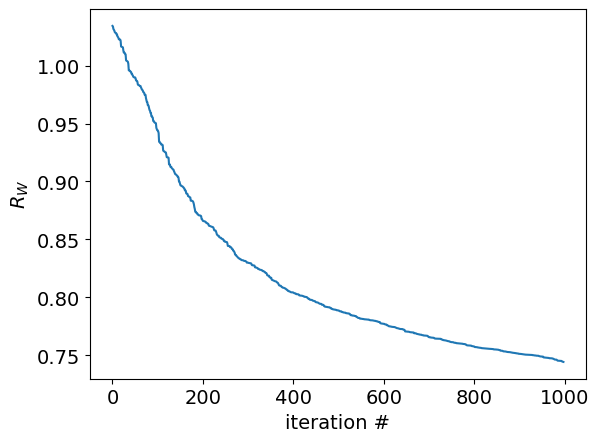

In [138]:
plt.plot(iter_array[1:999], resid_array[1:999])
plt.xlabel('iteration #')
plt.ylabel(r'$R_W$')

# print(r[400:1001])

# #These lines are important to run! They save the structure so that you can re-compute the G(r) and see how the structure looks!
# debye_to_excel = pd.ExcelWriter('fit_324structure_example.xlsx')
# data = pd.DataFrame(array_current) #array_current is the most recent iteration of the structure
# data.to_excel(debye_to_excel)
# debye_to_excel.save()

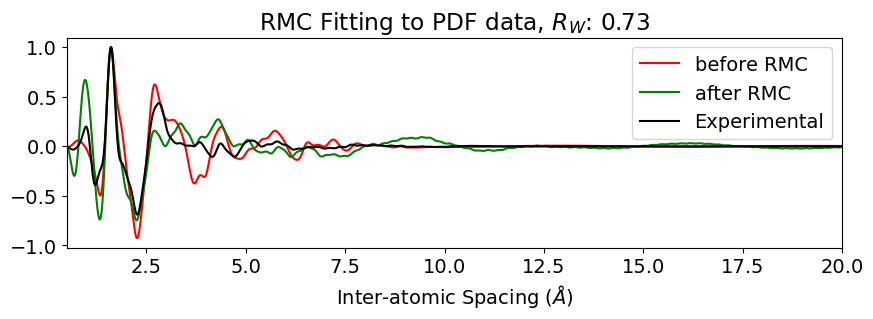

In [139]:
r = linspace(0,20,4001)
fig_1 = plt.figure(figsize=(10,6))

ax_1 = fig_1.add_subplot(2,1,1)
ax_1.plot(r, simu_compare, linestyle='solid', color='red',label="before RMC")
ax_1.plot(r, G_Rsimu_moved/np.max(G_Rsimu_moved), linestyle='solid', color='green',label="after RMC")
ax_1.plot(r, Exp_compare, linestyle='solid', color='k', label="Experimental")
ax_1.set_xlim(0.5,20)
ax_1.set_xlabel(r'Inter-atomic Spacing ($\AA$)')
ax_1.set_label('G(r)')
plt.title(r'RMC Fitting to PDF data, $R_W$: 0.73')

ax_1.legend()

# I'm going to move away from the legacy code below. Making changes above. Everything below is kept for convenience, later use, etc.

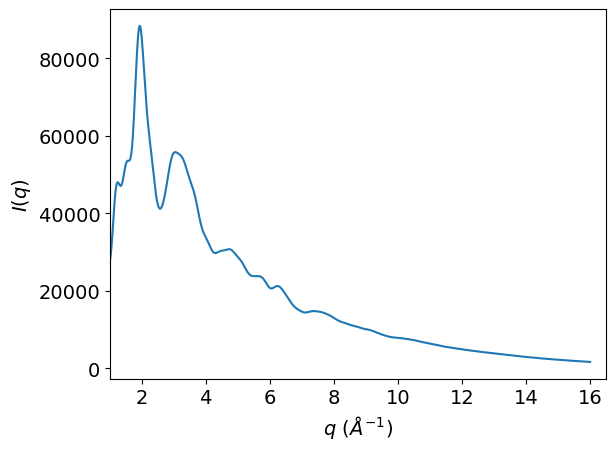

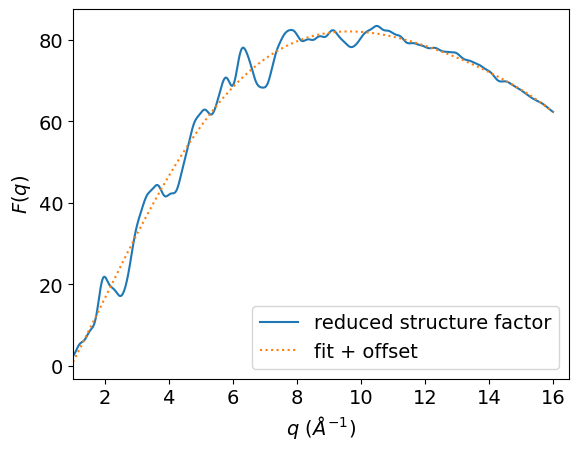

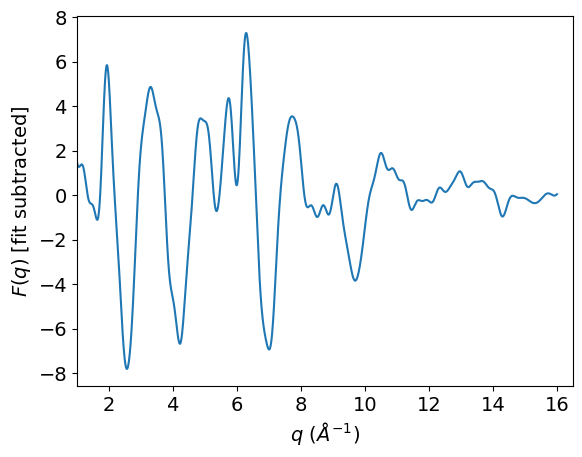

In [69]:
file2 = open(r"F313 - PDF - 1-16q - RT - cryo.txt")
data2 = file2.readlines()
beta =np.zeros((len(data2),))                         # this store the expectation values
for i in range (0,len(data2)):
    beta[i] = float(data2[i])
file2.close()

file2 = open(r"F324 - PDF - 1-16q - RT - cryo.txt")
data2 = file2.readlines()
alpha = np.zeros((len(data2),))                            # this store the expectation values
for i in range (0,len(data2)):
    alpha[i] = float(data2[i])
file2.close()

Form_Factor = correctness()
G_R = G_R_generation(I_Q,0,Form_Factor)

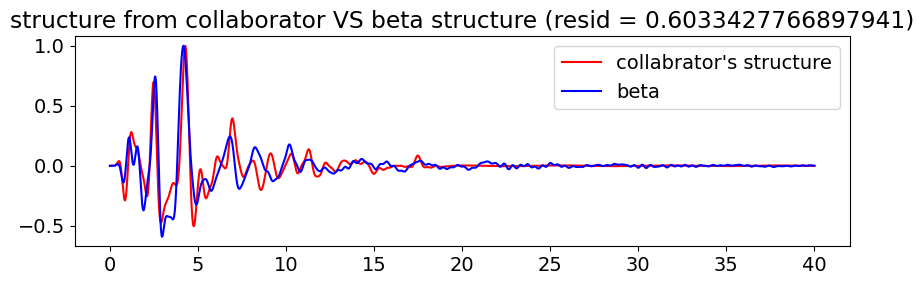

In [75]:
G_Rnorm = np.amax(G_R)
G_R_compare = G_R/ G_Rnorm
alpha_compare = alpha.copy()/max(alpha)
beta_compare = beta.copy()/max(beta)

residue_alpha_whole_R_range = sqrt(sum((alpha_compare.copy()[0:4001]-G_R_compare[0:4001])**2)/sum(alpha_compare.copy()[0:4001]**2))
residue_beta_whole_R_range = sqrt(sum((beta_compare.copy()[0:4001]-G_R_compare[0:4001])**2)/sum(beta_compare.copy()[0:4001]**2))

r = linspace(0,40,4001)
fig_1 = plt.figure(figsize=(10,6), num='Energy diagrams')
ax_1 = fig_1.add_subplot(2,1,1)
ax_1.plot(r, G_R_compare[0,:], linestyle='solid', color='red',label="collabrator's structure")
ax_1.plot(r, beta_compare, linestyle='solid', color='blue',label="beta")
plt.title('structure from collaborator VS beta structure (resid = 0.6033427766897941)')
ax_1.legend()